# Libraries

In [1]:
# Libraries
import os
import os.path as osp
import copy
import json
import pandas as pd
import numpy as np
from PIL import Image
from glob import glob

import mmcv

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

from mmcv import Config 
from mmdet.datasets import build_dataset 
from mmdet.models import build_detector 
from mmdet.apis import train_detector 
from mmdet.datasets import (build_dataloader, build_dataset, replace_ImageToTensor)

from mmdet.apis import set_random_seed

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import warnings
warnings.filterwarnings('ignore')

# Setting

In [2]:
# You can add more model configs like below.
MODELS_CONFIG = {
    'mask_rcnn': {
        'config_file': 'configs/mask_rcnn/mask_rcnn_r50_fpn_1x_coco.py'
    },
    # dir need to revise
    'detectors': {
        'config_file': 'configs/detectors/detectors_htc_r50_1x_coco.py',
    },
    'yolact': {
        'config_file': 'configs/yolact/yolact_r101_1x8_coco.py'
    }
}

In [3]:
# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'yolact'  # 'cascade_mask_rcnn_r50_fpn_1x'

# Name of the config file.
config_file = MODELS_CONFIG[selected_model]['config_file']

# Modify configuration

In [5]:
config_fname = os.path.join(config_file)

assert os.path.isfile(config_fname), '`{}` not exist'.format(config_fname)
config_fname

'configs/yolact/yolact_r101_1x8_coco.py'

In [6]:
dir = open("./data/train.json", "r", encoding="utf-8")
coco = json.load(dir)
print(coco["categories"])
classes_names = [category["name"] for category in coco["categories"]]
print(classes_names)

[{'id': 1, 'name': 'pet'}, {'id': 2, 'name': 'ps'}, {'id': 3, 'name': 'pp'}, {'id': 4, 'name': 'pe'}]
['pet', 'ps', 'pp', 'pe']


In [8]:
# config 파일 불러오기 
cfg = Config.fromfile(config_fname) 

print(f'Config:\n{cfg.pretty_text}')

Config:
checkpoint_config = dict(interval=1)
log_config = dict(interval=50, hooks=[dict(type='TextLoggerHook')])
custom_hooks = [dict(type='NumClassCheckHook')]
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = None
resume_from = None
workflow = [('train', 1)]
img_size = 550
model = dict(
    type='YOLACT',
    backbone=dict(
        type='ResNet',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=-1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        zero_init_residual=False,
        style='pytorch',
        init_cfg=dict(type='Pretrained',
                      checkpoint='torchvision://resnet101')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        start_level=1,
        add_extra_convs='on_input',
        num_outs=5,
        upsample_cfg=dict(mode='bilinear')),
    bbox_head=dict(
        type='YOLACTHead',
        num_cla

In [9]:
# config 파일 불러오기 
cfg = Config.fromfile(config_fname) 

# AssertionError: classification scores become infinite or NaN!
# if learning rate to high, an error comes out
cfg.optimizer = dict(type='SGD', lr=0.001, momentum=0.9, weight_decay=0.0005)
cfg.optimizer_config = dict(grad_clip=None)
cfg.lr_config = dict(policy='step', warmup='linear', warmup_iters=500, warmup_ratio=0.001, step=[8, 11])
cfg.total_epochs = 12
cfg.runner.max_epochs = 12

cfg.model.bbox_head.num_classes=4
cfg.model.mask_head.num_classes=4
cfg.model.segm_head.num_classes=4

# Modify dataset type and path
dataset_type = 'CocoDataset'
img_norm_cfg = dict(mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
data_root = '/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/data/'
classes = ('pet', 'ps', 'pp', 'pe')

train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True, with_mask=True),
    dict(type='Resize', img_scale=(768, 768), keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels', 'gt_masks']),]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='MultiScaleFlipAug',
        img_scale=(768, 768),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **img_norm_cfg),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),])]

cfg.data = dict(samples_per_gpu=8,workers_per_gpu=1,
    train=dict(
        type=dataset_type,
        classes = classes,
        ann_file=data_root + 'train.json',
        img_prefix=data_root + 'train',
        pipeline=train_pipeline),
    val=dict(
        type=dataset_type,
	    classes = classes,
        ann_file=data_root + 'val.json',
        img_prefix=data_root + 'test',
        pipeline=test_pipeline),
    test=dict(
        type=dataset_type,
	    classes = classes,
        ann_file=data_root + 'val.json',
        img_prefix=data_root + 'test',
        pipeline=test_pipeline))
cfg.evaluation = dict(metric=['bbox', 'segm'])

cfg.checkpoint_config = dict(interval=1)
cfg.work_dir = './log'
cfg.log_config = dict(interval=50, hooks=[dict(type='TextLoggerHook')])  # dict(type='TensorboardLoggerHook')

# yapf:enable
cfg.dist_params = dict(backend='nccl')
cfg.log_level = 'INFO'
cfg.load_from = 'checkpoints/yolact_r101_1x8_coco_20200908-4cbe9101.pth'
cfg.resume_from = None
cfg.workflow = [('train', 1)]

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
checkpoint_config = dict(interval=1)
log_config = dict(interval=50, hooks=[dict(type='TextLoggerHook')])
custom_hooks = [dict(type='NumClassCheckHook')]
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = 'checkpoints/yolact_r101_1x8_coco_20200908-4cbe9101.pth'
resume_from = None
workflow = [('train', 1)]
img_size = 550
model = dict(
    type='YOLACT',
    backbone=dict(
        type='ResNet',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=-1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        zero_init_residual=False,
        style='pytorch',
        init_cfg=dict(type='Pretrained',
                      checkpoint='torchvision://resnet101')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        start_level=1,
        add_extra_convs='on_input',
        num_outs=5,
        upsample_cfg=dict(mode='bilinear')),
    bbox_h

In [10]:
import gc
gc.collect()

# GPU 캐시 데이터 삭제 
import torch
torch.cuda.empty_cache() 

In [11]:
# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

loading annotations into memory...
Done (t=0.15s)
creating index...
index created!


2021-12-09 16:06:07,596 - mmdet - INFO - load checkpoint from local path: checkpoints/yolact_r101_1x8_coco_20200908-4cbe9101.pth
2021-12-09 16:06:07,698 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.conv_cls.weight: copying a param with shape torch.Size([243, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([15, 256, 3, 3]).
size mismatch for bbox_head.conv_cls.bias: copying a param with shape torch.Size([243]) from checkpoint, the shape in current model is torch.Size([15]).
size mismatch for segm_head.segm_conv.weight: copying a param with shape torch.Size([80, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([4, 256, 1, 1]).
size mismatch for segm_head.segm_conv.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([4]).
2021-12-09 16:06:07,701 - mmdet - INFO - Start running, host: kerrykim@KerryKim, work_dir: /home/kerrykim/PycharmPr

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


2021-12-09 16:06:43,976 - mmdet - INFO - Epoch [1][50/499]	lr: 9.890e-05, eta: 1:11:47, time: 0.725, data_time: 0.072, memory: 14803, loss_cls: 6.2986, loss_bbox: 0.4898, loss_segm: 2.1671, loss_mask: 7.4244, loss: 16.3799
2021-12-09 16:07:17,645 - mmdet - INFO - Epoch [1][100/499]	lr: 1.988e-04, eta: 1:08:37, time: 0.673, data_time: 0.020, memory: 14803, loss_cls: 3.0179, loss_bbox: 0.3018, loss_segm: 0.3363, loss_mask: 0.3899, loss: 4.0459
2021-12-09 16:07:51,369 - mmdet - INFO - Epoch [1][150/499]	lr: 2.987e-04, eta: 1:07:14, time: 0.674, data_time: 0.019, memory: 14803, loss_cls: 1.3202, loss_bbox: 0.2861, loss_segm: 0.2005, loss_mask: 3.5533, loss: 5.3601
2021-12-09 16:08:25,023 - mmdet - INFO - Epoch [1][200/499]	lr: 3.986e-04, eta: 1:06:13, time: 0.673, data_time: 0.021, memory: 14804, loss_cls: 0.7628, loss_bbox: 0.2385, loss_segm: 0.1349, loss_mask: 0.4309, loss: 1.5672
2021-12-09 16:08:59,276 - mmdet - INFO - Epoch [1][250/499]	lr: 4.985e-04, eta: 1:05:37, time: 0.685, data_t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 12.1 task/s, elapsed: 33s, ETA:     0s

2021-12-09 16:12:21,296 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.10s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.21s).
Accumulating evaluation results...


2021-12-09 16:12:21,664 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.825
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.983
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.828
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.827
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.863
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.863
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.863
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.829
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.05s).
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.32s).

/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-09 16:12:22,063 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.955
 Average Precision  (AP) @[ IoU=0.50 


Accumulating evaluation results...
DONE (t=0.05s).


/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/mmcv/runner/hooks/logger/text.py:112: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mem_mb = torch.tensor([mem / (1024 * 1024)],
2021-12-09 16:12:57,869 - mmdet - INFO - Epoch [2][50/499]	lr: 1.000e-03, eta: 0:56:35, time: 0.716, data_time: 0.073, memory: 14804, loss_cls: 0.2550, loss_bbox: 0.1524, loss_segm: 0.0387, loss_mask: 1.3684, loss: 1.8145
2021-12-09 16:13:31,422 - mmdet - INFO - Epoch [2][100/499]	lr: 1.000e-03, eta: 0:56:25, time: 0.671, data_time: 0.02

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 12.0 task/s, elapsed: 33s, ETA:     0s

2021-12-09 16:18:32,167 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2021-12-09 16:18:32,437 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.849
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.991
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.988
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.857
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.851
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.882
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.882
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.882
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.857
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.22s).
Accumulating evaluation results...
DONE (t=0.05s).
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-09 16:18:32,792 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.960
 Average Precision  (AP) @[ IoU=0.50 

DONE (t=0.27s).
Accumulating evaluation results...
DONE (t=0.05s).


/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/mmcv/runner/hooks/logger/text.py:112: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mem_mb = torch.tensor([mem / (1024 * 1024)],
2021-12-09 16:19:09,165 - mmdet - INFO - Epoch [3][50/499]	lr: 1.000e-03, eta: 0:50:48, time: 0.727, data_time: 0.074, memory: 14804, loss_cls: 0.1757, loss_bbox: 0.0842, loss_segm: 0.0294, loss_mask: 0.2361, loss: 0.5254
2021-12-09 16:19:42,267 - mmdet - INFO - Epoch [3][100/499]	lr: 1.000e-03, eta: 0:50:27, time: 0.662, data_time: 0.02

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 13.8 task/s, elapsed: 29s, ETA:     0s

2021-12-09 16:24:40,212 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.20s).
Accumulating evaluation results...


2021-12-09 16:24:40,452 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.878
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.987
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.886
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.880
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.908
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.908
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.908
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.886
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.04s).
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-09 16:24:40,752 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.966
 Average Precision  (AP) @[ IoU=0.50 

DONE (t=0.23s).
Accumulating evaluation results...
DONE (t=0.04s).


/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/mmcv/runner/hooks/logger/text.py:112: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mem_mb = torch.tensor([mem / (1024 * 1024)],
2021-12-09 16:25:17,327 - mmdet - INFO - Epoch [4][50/499]	lr: 1.000e-03, eta: 0:45:28, time: 0.731, data_time: 0.074, memory: 14804, loss_cls: 0.1121, loss_bbox: 0.0757, loss_segm: 0.0249, loss_mask: 2.3724, loss: 2.5850
2021-12-09 16:25:51,119 - mmdet - INFO - Epoch [4][100/499]	lr: 1.000e-03, eta: 0:45:06, time: 0.676, data_time: 0.02

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 13.8 task/s, elapsed: 29s, ETA:     0s

2021-12-09 16:30:54,536 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.19s).
Accumulating evaluation results...


2021-12-09 16:30:54,772 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.905
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.987
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.885
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.907
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.935
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.935
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.935
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.886
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.04s).
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.23s).
Accumulating evaluation results...


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-09 16:30:55,075 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.965
 Average Precision  (AP) @[ IoU=0.50 

DONE (t=0.04s).


/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/mmcv/runner/hooks/logger/text.py:112: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mem_mb = torch.tensor([mem / (1024 * 1024)],
2021-12-09 16:31:31,491 - mmdet - INFO - Epoch [5][50/499]	lr: 1.000e-03, eta: 0:40:28, time: 0.728, data_time: 0.073, memory: 14804, loss_cls: 0.0747, loss_bbox: 0.0557, loss_segm: 0.0159, loss_mask: 0.2688, loss: 0.4151
2021-12-09 16:32:05,402 - mmdet - INFO - Epoch [5][100/499]	lr: 1.000e-03, eta: 0:40:03, time: 0.678, data_time: 0.02

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 13.0 task/s, elapsed: 31s, ETA:     0s

2021-12-09 16:37:03,810 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2021-12-09 16:37:04,069 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.914
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.989
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.915
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.917
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.941
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.941
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.941
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.914
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.21s).
Accumulating evaluation results...
DONE (t=0.04s).
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-09 16:37:04,501 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.962
 Average Precision  (AP) @[ IoU=0.50 

DONE (t=0.25s).
Accumulating evaluation results...
DONE (t=0.04s).


/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/mmcv/runner/hooks/logger/text.py:112: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mem_mb = torch.tensor([mem / (1024 * 1024)],
2021-12-09 16:37:40,345 - mmdet - INFO - Epoch [6][50/499]	lr: 1.000e-03, eta: 0:35:17, time: 0.717, data_time: 0.074, memory: 14804, loss_cls: 0.0983, loss_bbox: 0.0542, loss_segm: 0.0235, loss_mask: 3.3269, loss: 3.5030
2021-12-09 16:38:13,202 - mmdet - INFO - Epoch [6][100/499]	lr: 1.000e-03, eta: 0:34:49, time: 0.657, data_time: 0.02

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 14.0 task/s, elapsed: 29s, ETA:     0s

2021-12-09 16:43:04,950 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.20s).
Accumulating evaluation results...


2021-12-09 16:43:05,198 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.910
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.995
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.992
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.929
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.912
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.936
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.936
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.936
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.929
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.04s).
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.24s).
Accumulating evaluation results...


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-09 16:43:05,500 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.967
 Average Precision  (AP) @[ IoU=0.50 

DONE (t=0.04s).


/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/mmcv/runner/hooks/logger/text.py:112: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mem_mb = torch.tensor([mem / (1024 * 1024)],
2021-12-09 16:43:40,753 - mmdet - INFO - Epoch [7][50/499]	lr: 1.000e-03, eta: 0:30:02, time: 0.705, data_time: 0.072, memory: 14804, loss_cls: 0.0834, loss_bbox: 0.0456, loss_segm: 0.0171, loss_mask: 1.4444, loss: 1.5905
2021-12-09 16:44:13,434 - mmdet - INFO - Epoch [7][100/499]	lr: 1.000e-03, eta: 0:29:33, time: 0.654, data_time: 0.02

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 12.9 task/s, elapsed: 31s, ETA:     0s

2021-12-09 16:49:06,468 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.21s).
Accumulating evaluation results...


2021-12-09 16:49:06,722 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.922
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.994
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.992
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.915
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.924
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.947
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.947
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.947
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.914
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.04s).
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.25s).
Accumulating evaluation results...


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-09 16:49:07,046 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.963
 Average Precision  (AP) @[ IoU=0.50 

DONE (t=0.04s).


/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/mmcv/runner/hooks/logger/text.py:112: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mem_mb = torch.tensor([mem / (1024 * 1024)],
2021-12-09 16:49:42,248 - mmdet - INFO - Epoch [8][50/499]	lr: 1.000e-03, eta: 0:24:51, time: 0.704, data_time: 0.073, memory: 14804, loss_cls: 0.0852, loss_bbox: 0.0403, loss_segm: 0.0170, loss_mask: 1.4058, loss: 1.5484
2021-12-09 16:50:14,881 - mmdet - INFO - Epoch [8][100/499]	lr: 1.000e-03, eta: 0:24:22, time: 0.653, data_time: 0.02

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 14.3 task/s, elapsed: 28s, ETA:     0s

2021-12-09 16:55:04,666 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2021-12-09 16:55:05,005 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.908
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.992
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.929
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.910
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.935
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.935
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.935
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.929
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.30s).
Accumulating evaluation results...
DONE (t=0.04s).
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-09 16:55:05,293 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.962
 Average Precision  (AP) @[ IoU=0.50 

DONE (t=0.23s).
Accumulating evaluation results...
DONE (t=0.04s).


/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/mmcv/runner/hooks/logger/text.py:112: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mem_mb = torch.tensor([mem / (1024 * 1024)],
2021-12-09 16:55:40,557 - mmdet - INFO - Epoch [9][50/499]	lr: 1.000e-04, eta: 0:19:43, time: 0.705, data_time: 0.073, memory: 14804, loss_cls: 0.0591, loss_bbox: 0.0289, loss_segm: 0.0124, loss_mask: 0.2075, loss: 0.3080
2021-12-09 16:56:13,131 - mmdet - INFO - Epoch [9][100/499]	lr: 1.000e-04, eta: 0:19:13, time: 0.651, data_time: 0.02

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 14.2 task/s, elapsed: 28s, ETA:     0s

2021-12-09 17:01:03,075 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.19s).
Accumulating evaluation results...


2021-12-09 17:01:03,309 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.947
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.992
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.915
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.949
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.965
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.965
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.965
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.914
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.04s).
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-09 17:01:03,598 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.961
 Average Precision  (AP) @[ IoU=0.50 

DONE (t=0.23s).
Accumulating evaluation results...
DONE (t=0.04s).


/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/mmcv/runner/hooks/logger/text.py:112: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mem_mb = torch.tensor([mem / (1024 * 1024)],
2021-12-09 17:01:38,883 - mmdet - INFO - Epoch [10][50/499]	lr: 1.000e-04, eta: 0:14:37, time: 0.705, data_time: 0.074, memory: 14804, loss_cls: 0.0314, loss_bbox: 0.0258, loss_segm: 0.0102, loss_mask: 0.2155, loss: 0.2829
2021-12-09 17:02:11,539 - mmdet - INFO - Epoch [10][100/499]	lr: 1.000e-04, eta: 0:14:08, time: 0.653, data_time: 0.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 14.1 task/s, elapsed: 28s, ETA:     0s

2021-12-09 17:07:01,593 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.19s).
Accumulating evaluation results...


2021-12-09 17:07:01,821 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.946
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.992
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.915
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.948
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.965
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.965
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.965
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.914
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.04s).
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-09 17:07:02,112 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.962
 Average Precision  (AP) @[ IoU=0.50 

DONE (t=0.22s).
Accumulating evaluation results...
DONE (t=0.04s).


/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/mmcv/runner/hooks/logger/text.py:112: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mem_mb = torch.tensor([mem / (1024 * 1024)],
2021-12-09 17:07:37,270 - mmdet - INFO - Epoch [11][50/499]	lr: 1.000e-04, eta: 0:09:34, time: 0.703, data_time: 0.072, memory: 14804, loss_cls: 0.0322, loss_bbox: 0.0211, loss_segm: 0.0113, loss_mask: 0.1903, loss: 0.2549
2021-12-09 17:08:09,906 - mmdet - INFO - Epoch [11][100/499]	lr: 1.000e-04, eta: 0:09:04, time: 0.653, data_time: 0.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 14.0 task/s, elapsed: 29s, ETA:     0s

2021-12-09 17:13:00,206 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.19s).
Accumulating evaluation results...


2021-12-09 17:13:00,438 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.947
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.990
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.929
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.950
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.966
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.966
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.966
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.929
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.04s).
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-09 17:13:00,729 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.963
 Average Precision  (AP) @[ IoU=0.50 

DONE (t=0.23s).
Accumulating evaluation results...
DONE (t=0.04s).


/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/mmcv/runner/hooks/logger/text.py:112: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mem_mb = torch.tensor([mem / (1024 * 1024)],
2021-12-09 17:13:36,040 - mmdet - INFO - Epoch [12][50/499]	lr: 1.000e-05, eta: 0:04:31, time: 0.706, data_time: 0.075, memory: 14804, loss_cls: 0.0642, loss_bbox: 0.0241, loss_segm: 0.0206, loss_mask: 1.1232, loss: 1.2321
2021-12-09 17:14:08,663 - mmdet - INFO - Epoch [12][100/499]	lr: 1.000e-05, eta: 0:04:01, time: 0.652, data_time: 0.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 14.0 task/s, elapsed: 28s, ETA:     0s

2021-12-09 17:18:58,861 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.19s).
Accumulating evaluation results...


2021-12-09 17:18:59,095 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.950
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.990
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.943
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.952
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.968
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.968
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.968
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.943
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.04s).
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-09 17:18:59,386 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.962
 Average Precision  (AP) @[ IoU=0.50 

DONE (t=0.23s).
Accumulating evaluation results...
DONE (t=0.04s).


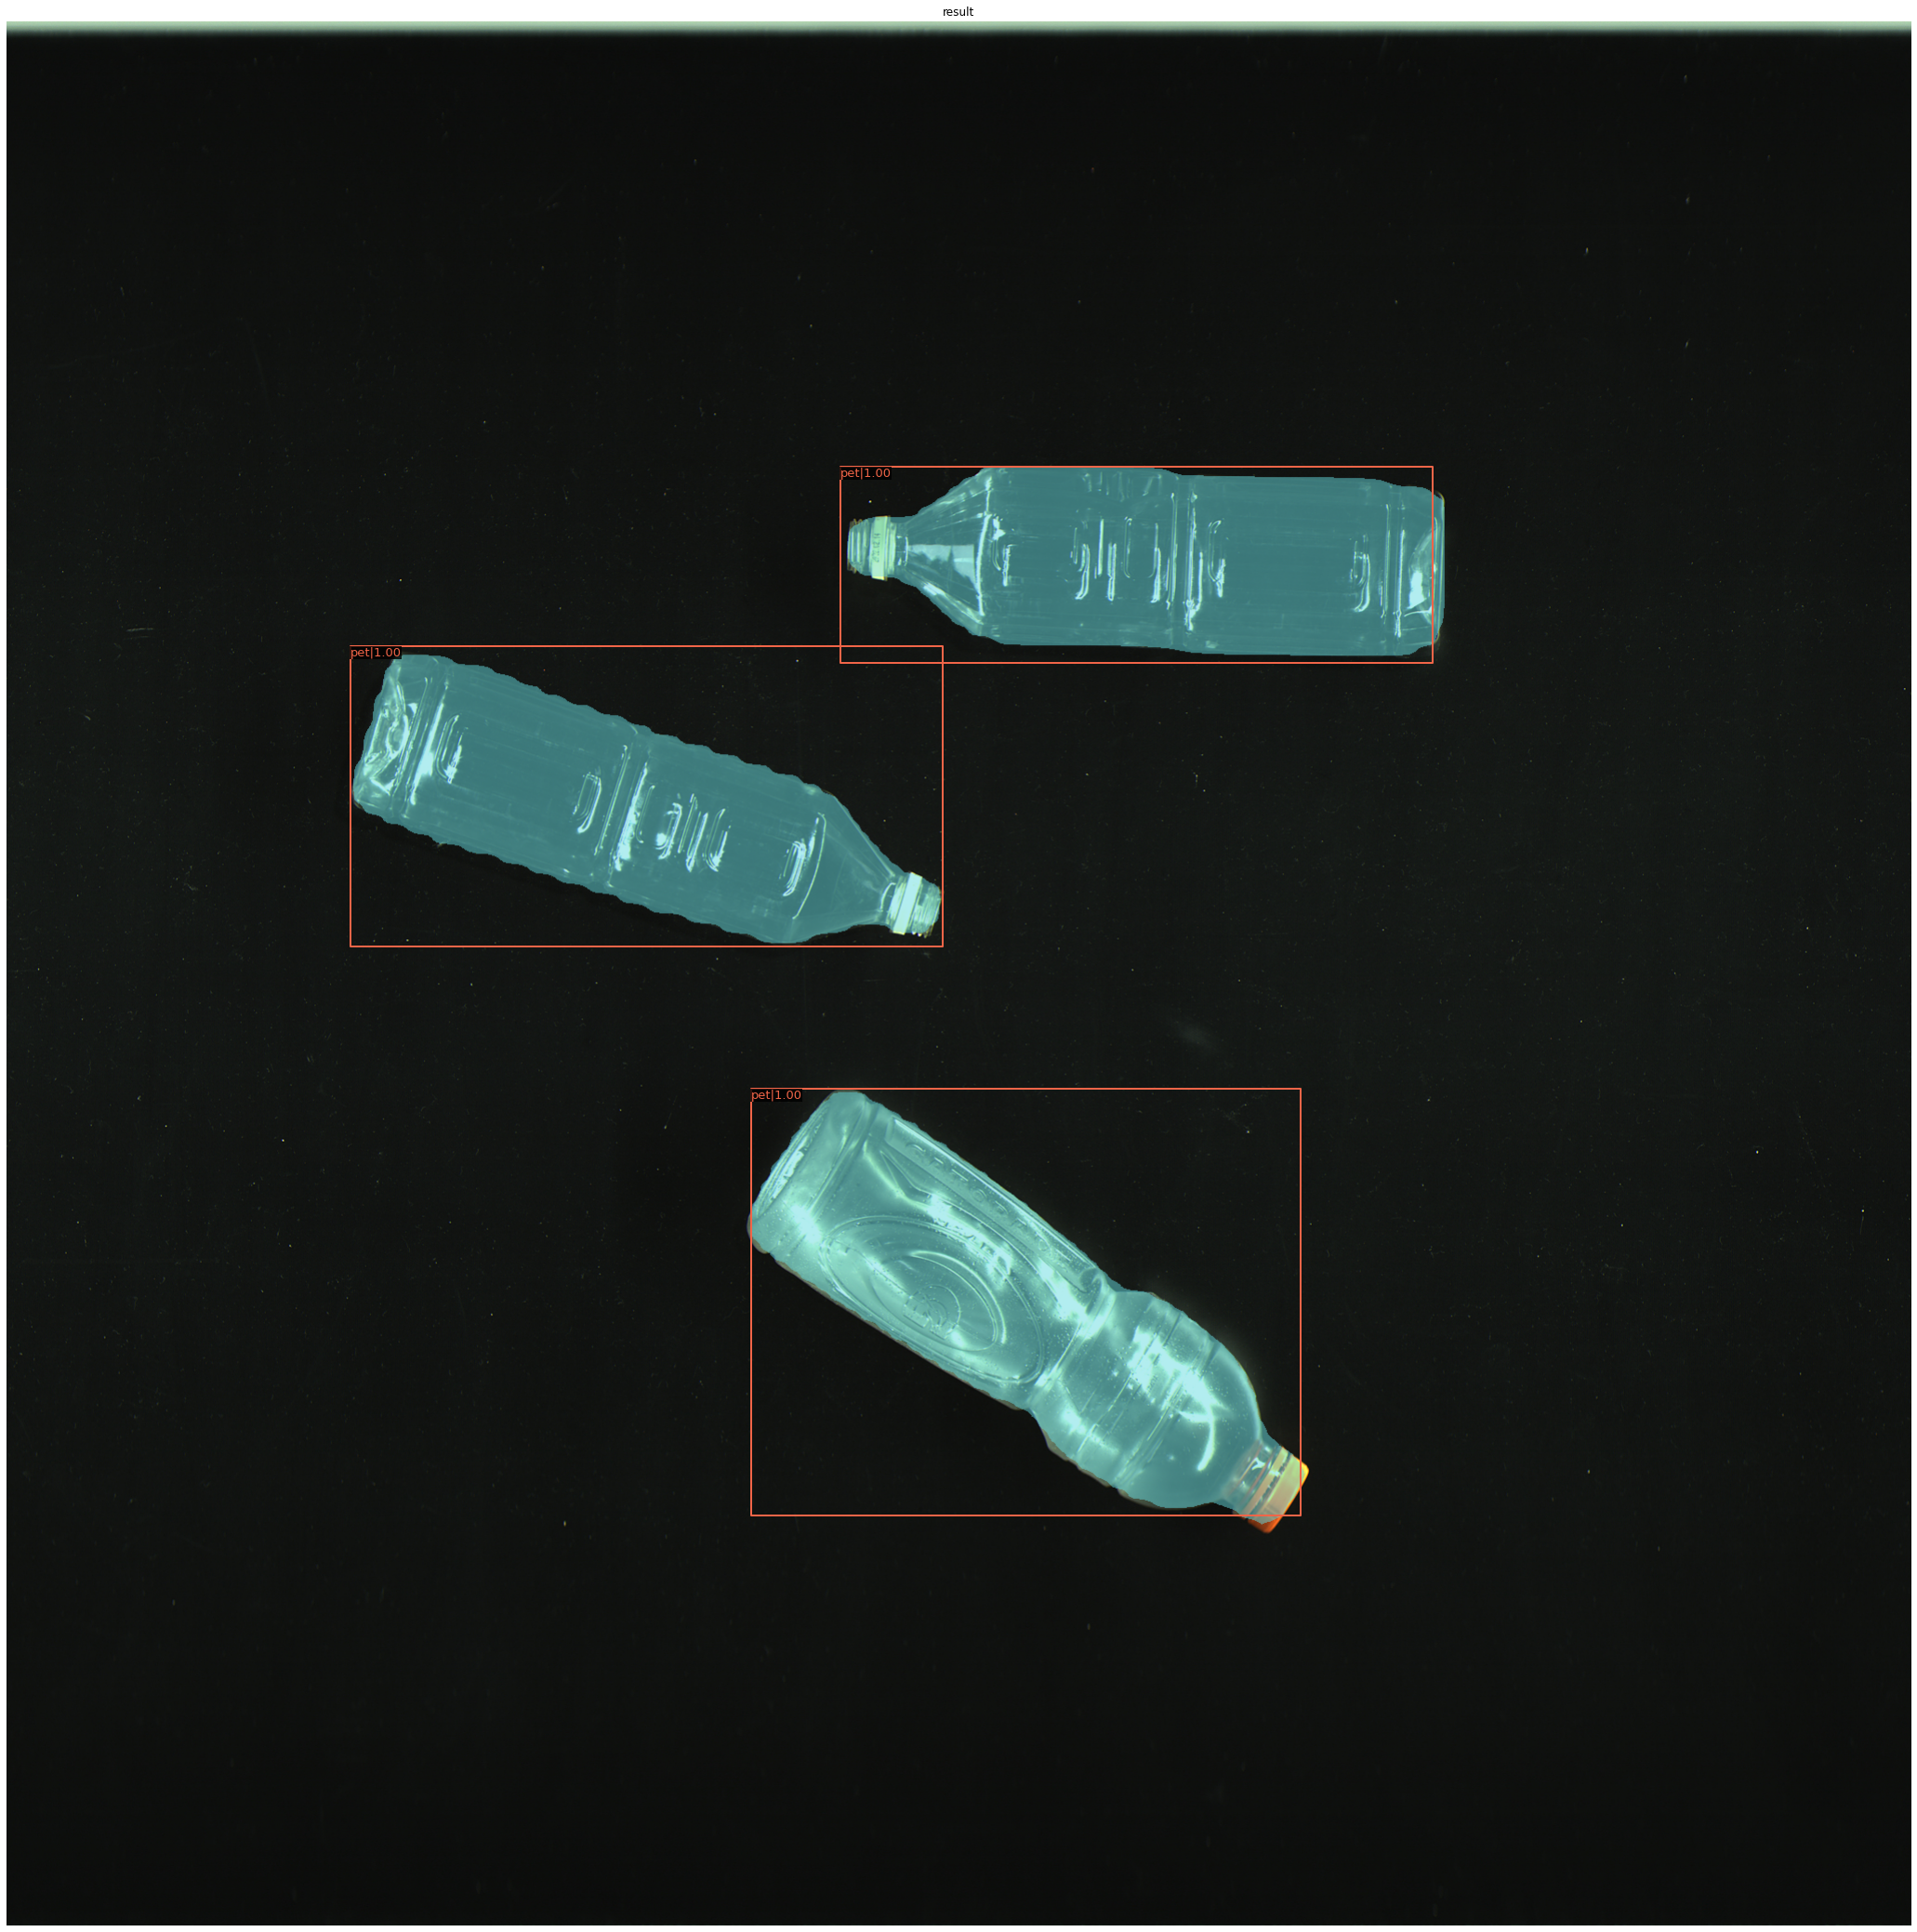

In [13]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

img = mmcv.imread('/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/data/test/PET_002_1241.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)